In [94]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random
from tqdm import tqdm
from scipy import stats
import networkx as nx

In [2]:
from torchvision.io import read_image
import torchvision.transforms as T

In [3]:
%load_ext autoreload
%autoreload 2

---

In [4]:
DATA_DIR = '/data/ltorres'

In [5]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

---

In [6]:
def get_paths(data_dir, dataset_type):
    return glob.glob(
                     os.path.join(data_dir,f'GCD/{dataset_type}/**/*.jpg'), 
                     recursive=True
                    )

In [7]:
train_paths = get_paths(DATA_DIR, "train")

In [8]:
random.shuffle(train_paths)

In [9]:
sample_paths = train_paths[:16]

---

# 1. Lectura de imagenes

In [10]:
images = []

for p in sample_paths:
    img = read_image(p).int()
    img = T.Resize(144)(img)
    images.append(img)

# 2. Visualizar la muestra

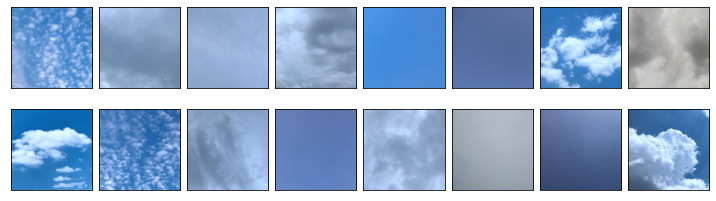

In [11]:
fig = plt.figure(figsize=(16, 16))
fig.set_figwidth(10)
fig.set_figheight(3)

columns = 8
rows = 2

##fig.suptitle('Muestra del conjunto de entrenamiento GCD', fontsize=14)

for i in range(1, 17):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.numpy().transpose(1,2,0)) 
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.4)

fig.tight_layout()
fig.savefig('assets/sample_gcd.png')
plt.show()

# 3. Tecnicas de construccion de la matriz de adyacencia

In [12]:
%cd ..

/home/ltorres/leo/Cloud-Classification/cloud_classification


In [34]:
from src.modules.conv_modules import CNNExtractor
from src.dataset import GCD

In [35]:
dataset = GCD(sample_paths, 256)

train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=16,
        num_workers=6,
        shuffle=False,
    )

In [95]:
batch = next(iter(train_loader))

In [96]:
cnn = CNNExtractor(feature_extraction=False)
cnn.eval()
print("initiated model")

initiated model


In [97]:
features = cnn(batch['images'])
features.shape

torch.Size([16, 2048])

- De la red convolucional se obtiene un vector de 2048 dimensiones por cada imagen

---

In [98]:
def normalize_features(dfs):
    norm = dfs.norm(dim=1).view(-1,1)
    return dfs/norm

## 3.1. Similitud de Coseno

In [99]:
def build_graph_cosine_similarity(deep_features, threshold):
    """
    returns a dgl graph built with an edge index calculated from the deep features 
    using cosine similarity
    """
    
    with torch.no_grad():
        batch_nodes = normalize_features(deep_features)

        sim_matrix = batch_nodes @ batch_nodes.T
        adj_matrix = torch.where(sim_matrix >= threshold, 1, 0)
 
    return adj_matrix

In [100]:
cos_sim_adj = build_graph_cosine_similarity(features, threshold=0.6)

In [101]:
cos_sim_adj.numpy()

array([[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]])

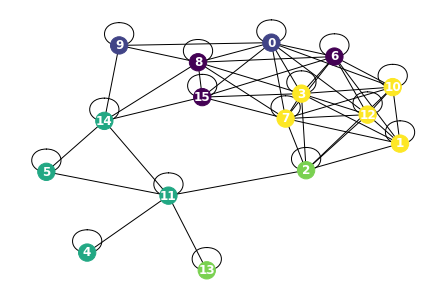

In [147]:
G = nx.from_numpy_matrix(cos_sim_adj.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(6,4)) 
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/cos_sim_graph.png')
plt.show()

## 3.2. Correlacion de Pearson

In [73]:
def build_graph_pearson_correlation(dfs, threshold):
    """
    returns a dgl graph built with an edge index calculated from the deep features 
    using pearson correlation
    """
    with torch.no_grad():
        corr_matrix = torch.corrcoef(dfs)
        adj_matrix = torch.where(corr_matrix >= threshold, 1, 0)
        row, col = torch.where(adj_matrix==1)
    
    return adj_matrix

In [92]:
pearson_corr_adj = build_graph_pearson_correlation(features, threshold=0.5)

In [93]:
pearson_corr_adj.numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]])

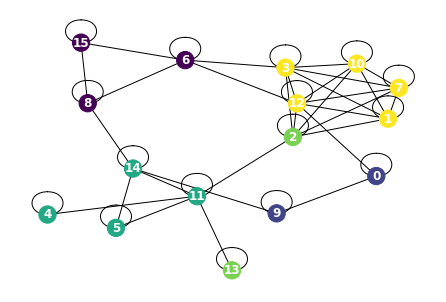

In [353]:
G = nx.from_numpy_matrix(pearson_corr_adj.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(6,4))
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/pearson_corr_graph.png')
plt.show()

## 3.2. Distancia Euclidiana

In [311]:
def pairwise_distance(x):
    
    x_inner = -2*torch.matmul(x, x.T)
    x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
    
    return torch.sqrt(x_square + x_inner + x_square.T) #SQRT((x - x.T)^2 = X^2 -2XX.T + X.T^2)

In [372]:
def build_graph_l2_distance(features, k):
    with torch.no_grad():
        distances = pairwise_distance(features)
        
        batch_size = features.shape[0]
        
        _, src_idx = torch.topk(-distances, k=k)
        dst_idx = torch.arange(0, batch_size).repeat_interleave(k)
        
        adj_mat = torch.zeros(batch_size, batch_size).long()
        adj_mat[src_idx.flatten(), dst_idx] = 1
        
        return adj_mat 

In [373]:
l2_adj = build_graph_l2_distance(features, 5)

In [374]:
l2_adj

tensor([[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]])

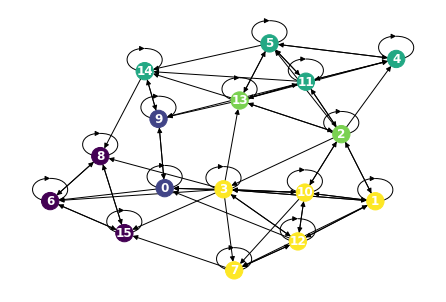

In [376]:
G = nx.from_numpy_matrix(l2_adj.numpy(), create_using=nx.DiGraph)

plt.figure(1,figsize=(6,4))
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/l2_distance_graph.png')
plt.show()